In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Please enter the path of the image : /content/gdrive/My Drive/darknet/test_images/1.png
You have entered the path => /content/gdrive/My Drive/darknet/test_images/1.png 

predicted class => AboveBB: 0.9222
predicted class => AboveCloud: 0.7828


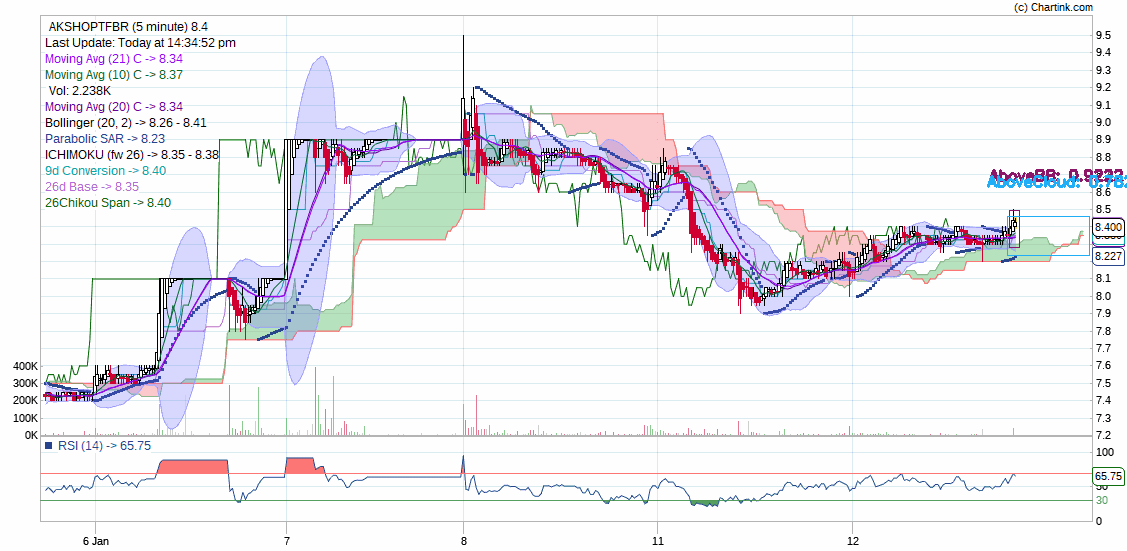

In [ ]:
import numpy as np
import time
import cv2
import glob
from google.colab.patches import cv2_imshow

OUTPUT_FILE='predicted.png'
LABELS_FILE='/content/gdrive/My Drive/darknet/obj.names'
CONFIG_FILE='/content/gdrive/My Drive/darknet/stock.cfg'
WEIGHTS_FILE='/content/gdrive/My Drive/darknet/backup/stock_4000.weights'
CONFIDENCE_THRESHOLD = 0.6


#INPUT_FILE='/content/gdrive/My Drive/darknet/test_images/1.png'
INPUT_FILE = input("Please enter the path of the image : ")
print(f"You have entered the path => {INPUT_FILE} \n")

try:
  LABELS = open(LABELS_FILE).read().strip().split("\n")

  np.random.seed(4)
  COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")


  net = cv2.dnn.readNetFromDarknet(CONFIG_FILE, WEIGHTS_FILE)

  image = cv2.imread(INPUT_FILE)
  (H, W) = image.shape[:2]

  # determine only the *output* layer names that we need from YOLO
  ln = net.getLayerNames()
  ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]


  blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
  net.setInput(blob)
  start = time.time()
  layerOutputs = net.forward(ln)
  end = time.time()


  #print("[INFO] YOLO took {:.6f} seconds".format(end - start))


  # initialize our lists of detected bounding boxes, confidences, and
  # class IDs, respectively
  boxes = []
  confidences = []
  classIDs = []

  # loop over each of the layer outputs
  for output in layerOutputs:
    # loop over each of the detections
    for detection in output:
      # extract the class ID and confidence (i.e., probability) of
      # the current object detection
      scores = detection[5:]
      classID = np.argmax(scores)
      confidence = scores[classID]

      # filter out weak predictions by ensuring the detected
      # probability is greater than the minimum probability
      if confidence > CONFIDENCE_THRESHOLD:
        # scale the bounding box coordinates back relative to the
        # size of the image, keeping in mind that YOLO actually
        # returns the center (x, y)-coordinates of the bounding
        # box followed by the boxes' width and height
        box = detection[0:4] * np.array([W, H, W, H])
        (centerX, centerY, width, height) = box.astype("int")

        # use the center (x, y)-coordinates to derive the top and
        # and left corner of the bounding box
        x = int(centerX - (width / 2))
        y = int(centerY - (height / 2))

        # update our list of bounding box coordinates, confidences,
        # and class IDs
        boxes.append([x, y, int(width), int(height)])
        confidences.append(float(confidence))
        classIDs.append(classID)

  # apply non-maxima suppression to suppress weak, overlapping bounding
  # boxes
  idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD,
    CONFIDENCE_THRESHOLD)

  # ensure at least one detection exists
  if len(idxs) > 0:
    # loop over the indexes we are keeping
    for i in idxs.flatten():
      # extract the bounding box coordinates
      (x, y) = (boxes[i][0], boxes[i][1])
      (w, h) = (boxes[i][2], boxes[i][3])

      color = [int(c) for c in COLORS[classIDs[i]]]

      cv2.rectangle(image, (x, y), (x + w, y + h), color, 1)
      text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
      print(f'predicted class => {text}')
      cv2.putText(image, text, (x-20, y - 30), cv2.FONT_HERSHEY_SIMPLEX,
        0.5, color, 2)

    # show the output image
    
    
    cv2.imwrite('/content/gdrive/My Drive/darknet/output/output.png', image)
    cv2_imshow(image)
except Exception as e:
  print("Exception while predicting", e)
  